<a href="https://colab.research.google.com/github/Hela-Mouelhi/battery-RUL-prediction/blob/main/Battery_RUL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn pandas matplotlib seaborn numpy scipy tensorflow keras lifelines h5py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy import stats
from scipy.special import gamma
from scipy.ndimage import uniform_filter1d
import h5py
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("✅ Toutes les bibliothèques sont installées et importées!")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=686e6000ae802ac168177564483d9a469af8d707b6e591ec53af6c7c3fc19ad4
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
✅ Toutes les bibliothèques sont installées et importées!


In [ ]:
!wget -q https://ssd.mathworks.com/supportfiles/predmaint/batterycyclelifeprediction/v2/batteryDischargeData.zip
!unzip -o batteryDischargeData.zip

Archive:  batteryDischargeData.zip
  inflating: batteryDischargeData.mat  
  inflating: license.txt             


In [ ]:
ls -lh /content/batteryDischargeData.mat

-rw-r--r-- 1 root root 945M Jul 19  2022 /content/batteryDischargeData.mat


In [ ]:
!file /content/batteryDischargeData.mat


/content/batteryDischargeData.mat: Matlab v5 mat-file (little endian) version 0x100, platform PCWIN64, created Tue Jul 19 12:14:22 2022


In [ ]:
from scipy.io import loadmat

data = loadmat('/content/batteryDischargeData.mat', squeeze_me=True, struct_as_record=False)


In [ ]:
b = data['batteryDischargeData']
print(type(b))
print("Shape:", b.shape)

<class 'numpy.ndarray'>
Shape: (40,)


In [ ]:
bat1 = b[0]
print(dir(bat1))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames', 'cycle_life', 'cycles']


In [ ]:
cycles_b1 = bat1.cycles
print("Number of cycles in battery 1:", len(cycles_b1))

Number of cycles in battery 1: 1008


In [ ]:
cycle1 = cycles_b1[0]

print("Fields in cycle 1:", cycle1._fieldnames)


Fields in cycle 1: ['discharge_dQdV', 'I', 'V', 'T', 'Qd']


In [ ]:
import scipy.io as sio
import numpy as np
import pandas as pd

# Load data
mat = sio.loadmat('/content/batteryDischargeData.mat', squeeze_me=True, struct_as_record=False)
batteries = mat['batteryDischargeData']  # 40 batteries

features_list = []

for b_idx in range(40):   # first 20 batteries
    b = batteries[b_idx]

    # cycle life
    cycle_life = b.cycle_life

    # first cycle
    cycle1 = b.cycles[0]

    dQdV = cycle1.discharge_dQdV
    I = cycle1.I
    V = cycle1.V
    T = cycle1.T
    Qd = cycle1.Qd

    # Feature extraction
    features = {
        'battery_id': b_idx+1,
        'cycle_life': int(cycle_life),
        'mean_dQdV': float(np.nanmean(dQdV)),
        'max_dQdV': float(np.nanmax(dQdV)),
        'temperature': float(np.nanmean(T)),
        'voltage': float(np.nanmean(V)),
        'current': float(np.nanmean(I)),
        'Qd': float(np.nanmean(Qd)),
    }

    features_list.append(features)

# Build dataframe
df = pd.DataFrame(features_list)

# Save CSV
df.to_csv('battery_features.csv', index=False)

print(df)


    battery_id  cycle_life  mean_dQdV  max_dQdV  temperature   voltage  \
0            1        1009  -0.746361  0.000000    32.149495  3.127287   
1            2        1063  -0.735478  0.000000    34.665376  3.117541   
2            3        1115  -0.737288  0.000000    36.336994  3.119966   
3            4        1048  -0.733971  0.000000    32.023968  3.127678   
4            5         828  -0.724831  0.000000    35.219950  3.113729   
5            6         667  -0.737982  0.000000    34.069715  3.114494   
6            7        1836  -0.737858  0.000000    32.759826  3.112286   
7            8         828  -0.732672  0.000000    32.963427  3.117357   
8            9        1039  -0.739496 -0.010332    33.045901  3.111098   
9           10        1078  -0.727745  0.000000    32.469591  3.106620   
10          11         817  -0.738004  0.000000    34.074084  3.118299   
11          12         932  -0.736803  0.000000    33.104749  3.122547   
12          13         816  -0.732242 

In [ ]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   battery_id   40 non-null     int64  
 1   cycle_life   40 non-null     int64  
 2   mean_dQdV    40 non-null     float64
 3   max_dQdV     40 non-null     float64
 4   temperature  40 non-null     float64
 5   voltage      40 non-null     float64
 6   current      40 non-null     float64
 7   Qd           40 non-null     float64
dtypes: float64(6), int64(2)
memory usage: 2.6 KB


,battery_id,cycle_life,mean_dQdV,max_dQdV,temperature,voltage,current,Qd
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,20.500000,1032.000000,-0.735967,-0.000609,33.995842,3.118246,-0.043495,0.300032
std,11.690452,308.598403,0.007395,0.002329,1.223697,0.006495,0.045073,0.005270
min,1.000000,541.000000,-0.765998,-0.010638,31.250966,3.101986,-0.148174,0.285567
25%,10.750000,827.250000,-0.737987,0.000000,33.038670,3.112621,-0.070992,0.297309
50%,20.500000,964.500000,-0.734602,0.000000,34.000650,3.119132,-0.031666,0.300497
75%,30.250000,1122.750000,-0.732953,0.000000,34.992138,3.122760,-0.015218,0.303952
max,40.000000,1935.000000,-0.722838,0.000000,36.336994,3.128501,0.026697,0.307727


In [ ]:
X = df.drop(columns=["battery_id", "cycle_life"])
y = df["cycle_life"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
y_pred = rf.predict(X_test)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.2f} cycles")
print(f"RMSE : {rmse:.2f} cycles")
print(f"R²   : {r2:.3f}")


MAE  : 198.52 cycles
RMSE : 238.01 cycles
R²   : 0.474


In [ ]:
importance = pd.Series(rf.feature_importances_, index=X.columns)
importance.sort_values(ascending=False)

,0
current,0.413088
voltage,0.181114
Qd,0.147937
mean_dQdV,0.141588
temperature,0.107809
max_dQdV,0.008463


In [ ]:
from scipy.stats import weibull_min


In [ ]:
cycle_life_data = y.values

beta, loc, eta = weibull_min.fit(cycle_life_data, floc=0)

print(f"Weibull shape (β): {beta:.2f}")
print(f"Weibull scale (η): {eta:.2f}")

Weibull shape (β): 3.35
Weibull scale (η): 1144.69


In [ ]:
t = np.linspace(0, cycle_life_data.max(), 1000)


In [ ]:
survival = np.exp(-(t / eta) ** beta)


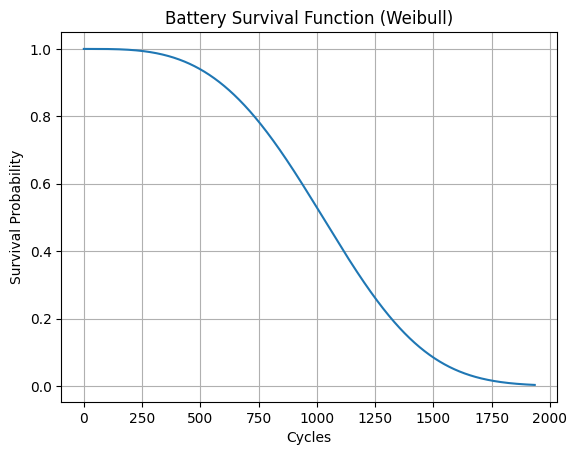

In [ ]:
plt.plot(t, survival)
plt.xlabel("Cycles")
plt.ylabel("Survival Probability")
plt.title("Battery Survival Function (Weibull)")
plt.grid()
plt.show()


In [ ]:
predicted_cycle_life = y_pred[0]
print(f"Predicted failure cycle: {predicted_cycle_life:.0f}")


Predicted failure cycle: 945


In [ ]:
survival_prob = np.exp(-(predicted_cycle_life / eta) ** beta)
failure_prob = 1 - survival_prob

print(f"Survival probability at predicted EOL: {survival_prob:.3f}")
print(f"Failure probability: {failure_prob:.3f}")


Survival probability at predicted EOL: 0.591
Failure probability: 0.409


In [ ]:
t_now = 500  # example

expected_life = predicted_cycle_life
RUL = expected_life - t_now

print(f"Estimated RUL: {RUL:.0f} cycles")


Estimated RUL: 445 cycles


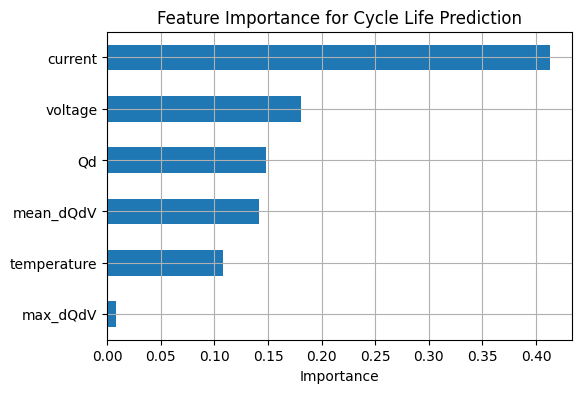

In [ ]:
importance.sort_values().plot(
    kind="barh",
    figsize=(6,4)
)
plt.title("Feature Importance for Cycle Life Prediction")
plt.xlabel("Importance")
plt.grid()
plt.show()


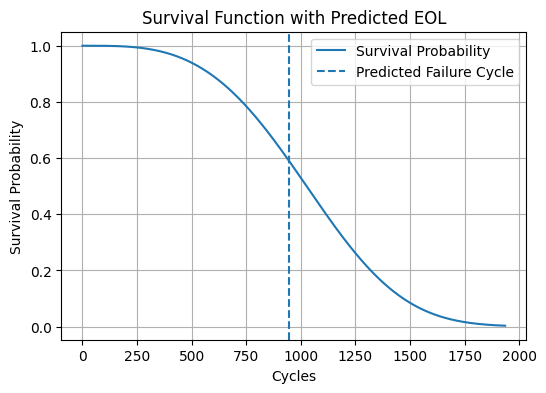

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(t, survival, label="Survival Probability")

plt.axvline(predicted_cycle_life,
            linestyle="--",
            label="Predicted Failure Cycle")

plt.xlabel("Cycles")
plt.ylabel("Survival Probability")
plt.title("Survival Function with Predicted EOL")
plt.legend()
plt.grid()
plt.show()


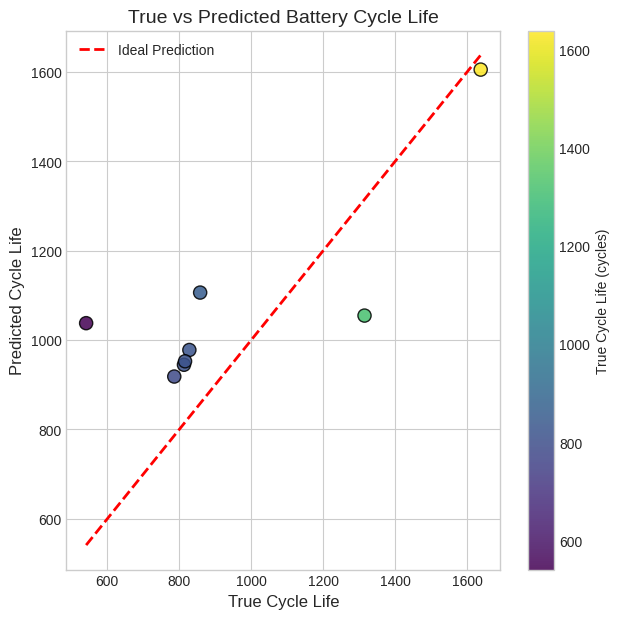

In [ ]:
plt.style.use("seaborn-v0_8-whitegrid")

TITLE_SIZE = 14
LABEL_SIZE = 12

plt.figure(figsize=(7,7))

plt.scatter(
    y_test,
    y_pred,
    c=y_test,
    cmap="viridis",
    s=90,
    edgecolors="black",
    alpha=0.85
)

plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Ideal Prediction"
)

plt.xlabel("True Cycle Life", fontsize=LABEL_SIZE)
plt.ylabel("Predicted Cycle Life", fontsize=LABEL_SIZE)
plt.title("True vs Predicted Battery Cycle Life", fontsize=TITLE_SIZE)
plt.colorbar(label="True Cycle Life (cycles)")
plt.legend()
plt.show()


In [ ]:
import joblib

joblib.dump(rf, "battery_lifetime_model.pkl")

['battery_lifetime_model.pkl']

In [ ]:
weibull_params = {
    "beta": 3.35,
    "eta": 1144.69
}

joblib.dump(weibull_params, "weibull_params.pkl")

['weibull_params.pkl']